In [1]:
HTML("""
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
</style>
""")

HTML{String}("<style>\n.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {\n     font-size: 100%;\n}\n</style>\n")

In [2]:
using PyPlot, PyCall
using AIBECS, WorldOceanAtlasTools
using LinearAlgebra

<img src="https://pbs.twimg.com/profile_images/1829321548/ess_logo_400x400.png" width=20% align=right>
<img src="https://user-images.githubusercontent.com/4486578/57202054-3d1c4400-6fe4-11e9-97d7-9a1ffbfcb2fc.png" width=20% align=left> 

<div style="text-align: center;">
    <span style="font-size: title"><h1>The F-1 algorithm</h1></span><br><br>
    <span style="color:#4063d8">Benoît Pasquier</span> and <span style="color:#4063d8">François Primeau</span><br>
    University of California, Irvine
</div>



<img src="https://user-images.githubusercontent.com/4486578/61258204-c657b000-a7b7-11e9-883a-f7d38a39d35c.png" width=18% align=right>

<span style="color:#4063d8"><b>Paper</b></span>: *The F-1 algorithm for efficient computation of the Hessian matrix of an objective function defined implicitly by the solution of a steady-state problem*
(under review)

<span style="color:#cb3c33"><b>Code</b></span>: <span style="color:#cb3c33"><b>F1Method.jl</b></span> (Julia package — check it out on GitHub!)

## F-1 algorithm – Outline

1. Motivation \& Context 
1. Autodifferentiation
1. What is the F-1 algorithm?
1. Benchmarks

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-color.png" width=25% align=right>
As we go through, I will demo some Julia code!

<img src="https://user-images.githubusercontent.com/4486578/60554111-8fc27400-9d79-11e9-9ca7-6d78ee89ea70.png" width=40% align=right>

# Motivation

For <span style="color:#cb3c33"><b>parameter optimization</b></span> and parameter sensitivity estimation!

The [**AIBECS**](https://github.com/briochemc/AIBECS.jl)
    *for building global marine steady-state biogeochemistry models in just a few commands*
    (yesterday's CCRC seminar)

And the <span style="color:#cb3c33"><b>F-1 algorithm</b></span> to facilitate optimization of biogeochemical parameters.

But the context of the **F-1 algorithm** is more general...

# Context

<span style="color:#9558b2"><b>Steady-state</b></span> equation

<span style="color:#9558b2">$$\frac{\partial \boldsymbol{x}}{\partial t} = \boldsymbol{F}(\boldsymbol{x},\boldsymbol{p}) = 0$$</span>

for some <span style="color:#4063d8">state $\boldsymbol{x}$</span> (size $n \sim 400\,000$) and <span style="color:#4063d8">parameters $\boldsymbol{p}$</span> (size $m \sim 10$).

<span style="color:#cb3c33"><b>Constrained optimization</b></span> problem

$$\left\{\begin{aligned}
        \mathop{\textrm{minimize}}_{\boldsymbol{x}, \boldsymbol{p}} & & f(\boldsymbol{x}, \boldsymbol{p}) \\
        \textrm{subject to} & & \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0
    \end{aligned}\right.$$

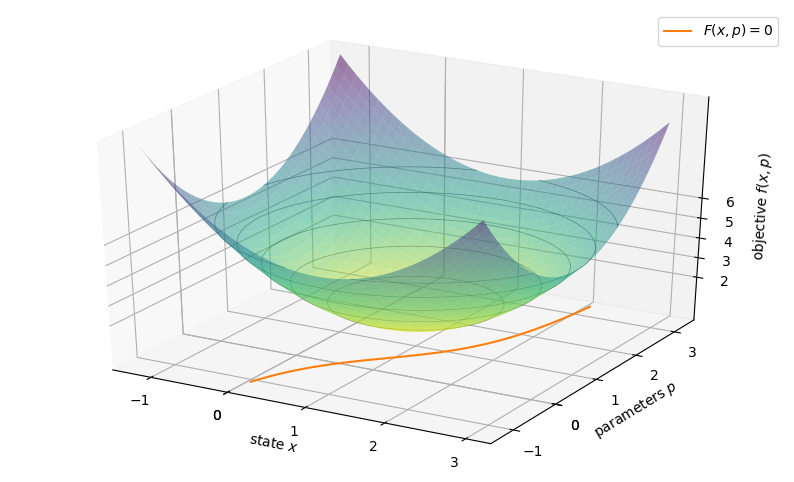

(PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x140778470>, getfield(Main, Symbol("#f#5"))(), getfield(Main, Symbol("#s#6"))(), -1.2:0.1:3.0, -1.2:0.1:3.2)

In [3]:
function constrained_optimization_plot()
    figure(figsize=(10,6))
    f(x,p) = (x - 1)^2 + (p - 1)^2 + 1
    s(p) = 1 + 0.9atan(p - 0.3)
    xs, ps = -1.2:0.1:3, -1.2:0.1:3.2
    plt = plot_surface(xs, ps, [f(x,p) for p in ps, x in xs], alpha = 0.5, cmap=:viridis_r)
    gca(projection="3d")
    P = repeat(reshape(ps, length(ps), 1), outer = [1, length(xs)])
    X = repeat(reshape(xs, 1, length(xs)), outer = [length(ps), 1])
    contour(X, P, [f(x,p) for p in ps, x in xs], levels = 2:6, colors="black", alpha=0.5, linewidths=0.5)
    plot([s(p) for p in ps], ps)
    legend(("\$F(x,p) = 0\$",))
    xlabel("state \$x\$"); ylabel("parameters \$p\$"); zlabel("objective \$f(x,p)\$")
    xticks(unique(round.(xs))); yticks(unique(round.(ps))); zticks(2:6)
    return plt, f, s, xs, ps
end
constrained_optimization_plot()

<span style="color:#cb3c33"><b>Unconstrained optimization</b></span> along the manifold of steady-state solutions.

<span style="color:#cb3c33">$$\mathop{\textrm{minimize}}_\boldsymbol{p} \hat{f}(\boldsymbol{p})$$</span>

where 
<span style="color:#9558b2">$$\hat{f}(\boldsymbol{p}) \equiv f\big(\boldsymbol{s}(\boldsymbol{p}), \boldsymbol{p}\big)$$</span> 
is the <span style="color:#9558b2"><b>objective</b></span> function.

And <span style="color:#4063d8">$\boldsymbol{s}(\boldsymbol{p})$</span> is the <span style="color:#4063d8"><b>steady-state solution</b></span> for parameters <span style="color:#4063d8">$\boldsymbol{p}$</span>, i.e., such that

$$\boldsymbol{F}\left(\boldsymbol{s}(\boldsymbol{p}),\boldsymbol{p}\right) = 0$$

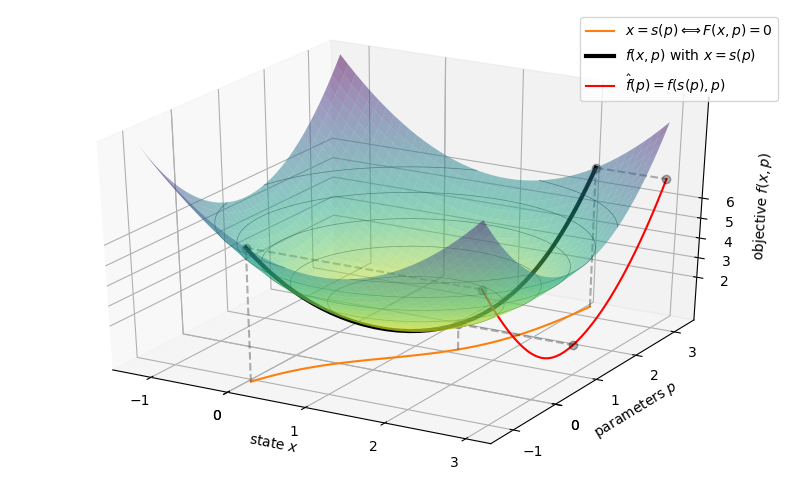

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x1413973c8>

In [4]:
function unconstrained_optimization_plot()
    plt, f, s, xs, ps = constrained_optimization_plot()
    plot([s(p) for p in ps], ps, [f(s(p),p) for p in ps], color="black", linewidth=3)
    plot(maximum(xs) * ones(length(ps)), ps, [f(s(p),p) for p in ps], color="red")
    legend(("\$x=s(p) \\Longleftrightarrow F(x,p)=0\$","\$f(x,p)\$ with \$x = s(p)\$", "\$\\hat{f}(p) = f(s(p),p)\$"))
    for p in ps[1:22:end]
        plot(s(p) * [1,1], p * [1,1], f(s(p),p) * [0,1], color="black", alpha = 0.3, linestyle="--")
        plot([s(p), maximum(xs)], p * [1,1], f(s(p),p) * [1,1], color="black", alpha = 0.3, linestyle="--", marker="o")
    end
    return plt
end
unconstrained_optimization_plot()

<img src="https://user-images.githubusercontent.com/4486578/61255958-25b0c280-a7ae-11e9-9d4c-7cd246e94e69.png" width=50% align=right>

Two **nested** iterative algorithms

<span style="color:#cb3c33"><b>Inner solver</b></span> with Newton step

$$\Delta \boldsymbol{x} \equiv - \left[\nabla_\boldsymbol{x} \boldsymbol{F}(\boldsymbol{x},\boldsymbol{p})\right]^{-1} \boldsymbol{F}(\boldsymbol{x},\boldsymbol{p})$$

Outer <span style="color:#cb3c33"><b>Optimizer</b></span> with Newton step

$$\Delta\boldsymbol{p} \equiv - \left[\nabla^2\hat{f}(\boldsymbol{p})\right]^{-1}\nabla \hat{f}(\boldsymbol{p})$$

requires <span style="color:#389826">the Hessian</span> of the objective function, 

<span style="color:#389826">$$\nabla^2 \hat{f}(\boldsymbol{p})$$</span>

# Autodifferentiation

Take the **Taylor expansion** of $\hat{f}(\boldsymbol{p})$ in the $h\boldsymbol{e}_j$ direction for a given $h$:

$$\hat{f}(\boldsymbol{p} + h \boldsymbol{e}_j)
    = \hat{f}(\boldsymbol{p})
    + h \underbrace{\nabla\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j}_{?}
    + \frac{h^2}{2} \, \left[\boldsymbol{e}_j^\mathsf{T} \, \nabla^2\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j\right]
    + \ldots$$

A standard solution is to use <span style="color:#964b00"><b>Finite differences</b></span>:

<span style="color:#964b00">$$\nabla\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j = \frac{\hat{f}(\boldsymbol{p} + h \boldsymbol{e}_j) - \hat{f}(\boldsymbol{p})}{h} + \mathcal{O}(h)$$</span>

But <span style="color:#cb3c33">truncation</span> and <span style="color:#cb3c33">round-off</span> errors!

A better solution is to use <span style="color:#9558b2"><b>Complex</b></span> numbers!<br>
Taylor-expand in the $ih\boldsymbol{e}_j$ direction:
$$\hat{f}(\boldsymbol{p} + i h \boldsymbol{e}_j) = \hat{f}(\boldsymbol{p}) + i h \underbrace{\nabla\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j}_{?} - \frac{h^2}{2} \, \left[\boldsymbol{e}_j^\mathsf{T} \, \nabla^2\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j\right] + \ldots$$

Because when taking the imaginary part, the convergence is faster and there are no more round-off errors:

<span style="color:#9558b2">$$\nabla\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j = \Im\left[\frac{\hat{f}(\boldsymbol{p} + i h \boldsymbol{e}_j)}{h}\right] + \mathcal{O}(h^2)$$</span>


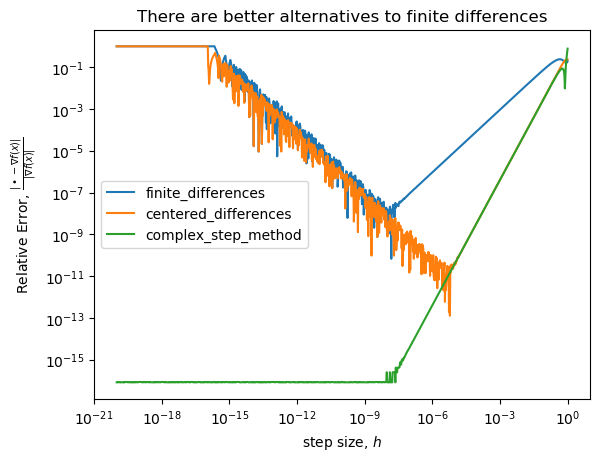

PyObject Text(0.5, 1, 'There are better alternatives to finite differences')

In [5]:
𝑓(x) = cos(x^2) + exp(x)
∇𝑓(x) = -2x * sin(x^2) + exp(x)
finite_differences(f, x, h) = (f(x + h) - f(x)) / h
centered_differences(f, x, h) = (f(x + h) - f(x - h)) / 2h
complex_step_method(f, x, h) = imag(f(x + im * h)) / h
relative_error(m, f, ∇f, x, h) = Float64(abs(BigFloat(m(f, x, h)) - ∇f(BigFloat(x))) / abs(∇f(x)))
x, step_sizes = 2.0, 10 .^ (-20:0.02:0)
numerical_schemes = [finite_differences, centered_differences, complex_step_method]
plot(step_sizes, [relative_error(m, 𝑓, ∇𝑓, x, h) for h in step_sizes, m in numerical_schemes])
loglog(), legend(string.(numerical_schemes)), xlabel("step size, \$h\$"), ylabel("Relative Error, \$\\frac{|\\bullet - \\nabla f(x)|}{|\\nabla f(x)|}\$")
title("There are better alternatives to finite differences")

An even better solution is to use <span style="color:#389826"><b>Dual</b></span> numbers! 

Define <span style="color:#389826">$\varepsilon \ne 0$</span> s.t. <span style="color:#389826">$\varepsilon^2 = 0$</span>, then the complete Taylor expansion in the $\varepsilon \boldsymbol{e}_j$ direction is

$$\hat{f}(\boldsymbol{p} + \varepsilon \boldsymbol{e}_j)
    = \hat{f}(\boldsymbol{p})
    + \varepsilon \underbrace{\nabla\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j}_{?}$$

Hence, 1st derivatives are given <span style="color:#389826"><b>exactly</b></span> by

<span style="color:#389826">$$\nabla\hat{f}(\boldsymbol{p}) \, \boldsymbol{e}_j = \mathfrak{D}\left[\hat{f}(\boldsymbol{p} + \varepsilon \boldsymbol{e}_j)\right]$$</span>

where <span style="color:#389826">$\mathfrak{D}$</span> is the dual part (the <span style="color:#389826">$\varepsilon$</span> coefficient).

The dual number <span style="color:#389826">$\varepsilon$</span> behaves like an <span style="color:#389826"><b>infinitesimal</b></span> and it gives very accurate derivatives!<br>

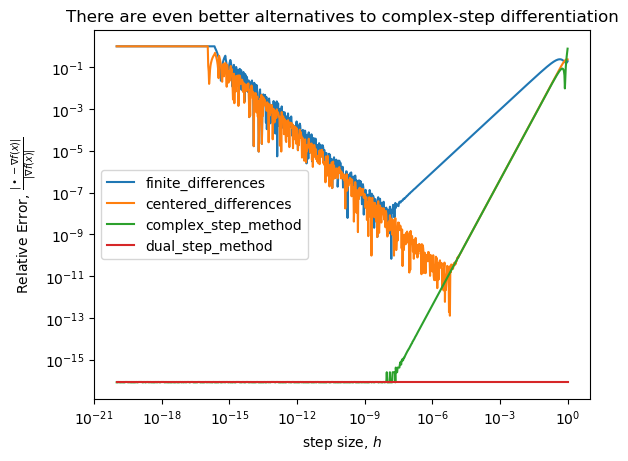

PyObject Text(0.5, 1, 'There are even better alternatives to complex-step differentiation')

In [6]:
using DualNumbers
dual_step_method(f, x, h) = dualpart(f(x + ε))
push!(numerical_schemes, dual_step_method)
plot(step_sizes, [relative_error(m, 𝑓, ∇𝑓, x, h) for h in step_sizes, m in numerical_schemes])
loglog(), legend(string.(numerical_schemes)), xlabel("step size, \$h\$"), ylabel("Relative Error, \$\\frac{|\\bullet - \\nabla f(x)|}{|\\nabla f(x)|}\$")
title("There are even better alternatives to complex-step differentiation")

Just like complex identify with $\mathbb{R}[X]/(X^2+1)$,<br>
dual numbers identify with $\mathbb{R}[X]/(X^2)$

The <span style="color:#389826"><b>gradient</b></span> of the objective function can be computed in $m$ dual evaluations of the objective function, via

<span style="color:#389826">$$\nabla\hat{f}(\boldsymbol{p}) = \mathfrak{D} \left( \left[\begin{matrix}
		\hat{f}(\boldsymbol{p} + \varepsilon \boldsymbol{e}_1) \\
		\hat{f}(\boldsymbol{p} + \varepsilon \boldsymbol{e}_2) \\
		\vdots \\
        \hat{f}(\boldsymbol{p} + \varepsilon \boldsymbol{e}_{m})
    \end{matrix} \right]^\mathsf{T} \right)$$</span>
    
where $m$ is the number of parameters.

For second derivatives, we can use <span style="color:#4063d8">hyperdual</span> numbers.<br>
Let <span style="color:#4063d8">$\varepsilon_1$</span> and <span style="color:#4063d8">$\varepsilon_2$</span> be the hyperdual units defined by <span style="color:#4063d8">$\varepsilon_1^2 = \varepsilon_2^2 = 0$</span> but <span style="color:#4063d8">$\varepsilon_1 \varepsilon_2 \ne 0$</span>.

Let <span style="color:#4063d8">$\boldsymbol{p}_{jk} = \boldsymbol{p} + \varepsilon_1 \boldsymbol{e}_j + \varepsilon_2 \boldsymbol{e}_k$</span>, for which the Taylor expansion of $\hat{f}$ is

$$\hat{f}(\boldsymbol{p}_{jk})
    = \hat{f}(\boldsymbol{p})
    + \varepsilon_1 \nabla\hat{f}(\boldsymbol{p}) \boldsymbol{e}_j
    + \varepsilon_2 \nabla\hat{f}(\boldsymbol{p}) \boldsymbol{e}_k
    + \varepsilon_1 \varepsilon_2 \underbrace{\boldsymbol{e}_j^\mathsf{T} \nabla^2\hat{f}(\boldsymbol{p}) \boldsymbol{e}_k}_{?}$$

Taking the "hyperdual" part gives the second derivative:

<span style="color:#4063d8">$$\boldsymbol{e}_j^\mathsf{T} \nabla^2\hat{f}(\boldsymbol{p}) \boldsymbol{e}_k = \mathfrak{H}\left[\hat{f}(\boldsymbol{p}_{jk})\right]$$</span>

where <span style="color:#4063d8">$\mathfrak{H}$</span> stands for hyperdual part (the $\varepsilon_1 \varepsilon_2$ coefficient).

<span style="color:#4063d8">Hyperdual</span> steps also give very accurate derivatives!

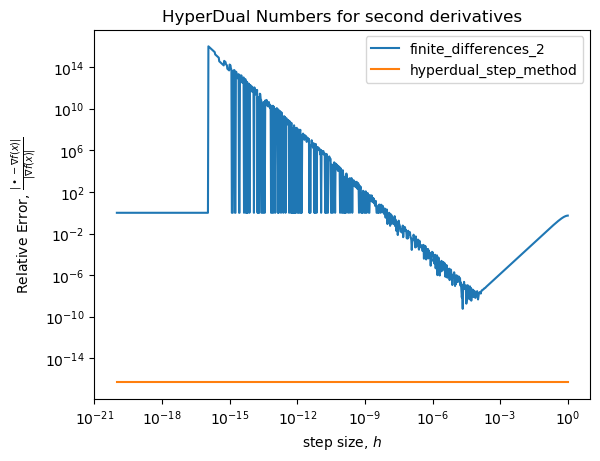

PyObject Text(0.5, 1, 'HyperDual Numbers for second derivatives')

In [7]:
∇²𝑓(x) = -2sin(x^2) - 4x^2 * cos(x^2) + exp(x)
using HyperDualNumbers
finite_differences_2(f, x, h) = (f(x + h) - 2f(x) + f(x - h)) / h^2
hyperdual_step_method(f, x, h) = ε₁ε₂part(f(x + ε₁ + ε₂))
numerical_schemes_2 = [finite_differences_2, hyperdual_step_method]
plot(step_sizes, [relative_error(m, 𝑓, ∇²𝑓, x, h) for h in step_sizes, m in numerical_schemes_2])
loglog(), legend(string.(numerical_schemes_2)), xlabel("step size, \$h\$"), ylabel("Relative Error, \$\\frac{|\\bullet - \\nabla f(x)|}{|\\nabla f(x)|}\$")
title("HyperDual Numbers for second derivatives")

### <span style="color:#cb3c33">Autodifferentiating through an iterative solver is expensive</span>

The <span style="color:#4063d8">Hessian</span> of $\hat{f}$ can be computed in $\frac{m(m+1)}{2}$ hyperdual evaluations:

<span style="color:#4063d8">$$\nabla^2\hat{f}(\boldsymbol{p}) = \mathfrak{H} \left( \left[\begin{matrix}
		\hat{f}(\boldsymbol{p}_{11})
        & \hat{f}(\boldsymbol{p}_{12})
        & \cdots
        & \hat{f}(\boldsymbol{p}_{1m})
        \\
		\hat{f}(\boldsymbol{p}_{12})
        & \hat{f}(\boldsymbol{p}_{22})
        & \cdots
        & \hat{f}(\boldsymbol{p}_{2m})
        \\
        \vdots & \vdots & \ddots & \vdots \\
		\hat{f}(\boldsymbol{p}_{1m})
        & \hat{f}(\boldsymbol{p}_{2m})
        & \cdots
        & \hat{f}(\boldsymbol{p}_{mm})
    \end{matrix} \right] \right)$$</span>


But this requires <span style="color:#cb3c33">$\frac{m(m+1)}{2}$ calls to the inner solver</span>, which requires <span style="color:#cb3c33">hyperdual factorizations</span>, and <span style="color:#cb3c33">fine-tuned non-real tolerances</span>!

# What is the F-1 algorithm

### What does it do?

The F-1 algorithm allows you to calculate the <span style="color:#389826"><b>gradient</b></span> and <span style="color:#4063d8"><b>Hessian</b></span> of an objective function, $\hat{f}(\boldsymbol{p})$, defined implicitly by the solution of a steady-state problem.

### How does it work?

It leverages analytical shortcuts, combined with <span style="color:#389826"><b>dual</b></span> and <span style="color:#4063d8"><b>hyperdual</b></span> numbers, to avoid calls to the inner solver and unnecessary factorizations.

### Analytical <span style="color:#389826">gradient</span>

Differentiate the objective function $\hat{f}(\boldsymbol{p}) = f\left(\boldsymbol{s}(\boldsymbol{p}), \boldsymbol{p}\right)$:

<img src="https://user-images.githubusercontent.com/4486578/62348010-0e5c2e00-b53f-11e9-9276-ef7fba0a1bba.png" width=40% align=right>

$$\color{forestgreen}{\underbrace{\nabla\hat{f}(\boldsymbol{p})}_{1 \times m}}
    = \color{royalblue}{\underbrace{\nabla_\boldsymbol{x}f(\boldsymbol{s}, \boldsymbol{p})_{\vphantom{\boldsymbol{p}}}}_{1 \times n}} \,
     \color{red}{\underbrace{\nabla \boldsymbol{s}(\boldsymbol{p})_{\vphantom{\boldsymbol{p}}}}_{n \times m}}
    + \color{DarkOrchid}{\underbrace{\nabla_\boldsymbol{p} f(\boldsymbol{s}, \boldsymbol{p})}_{1 \times m}}$$

Differentiate the steady-state equation, $\boldsymbol{F}\left(\boldsymbol{s}(\boldsymbol{p}),\boldsymbol{p}\right)=0$:  

<img src="https://user-images.githubusercontent.com/4486578/62348830-3ea4cc00-b541-11e9-8ee9-2eddb0fa64eb.png" width=40% align=right>

$$\color{royalblue}{\underbrace{\mathbf{A}_{\vphantom{\boldsymbol{p}}}}_{n \times n}} \,
     \color{red}{\underbrace{\nabla\boldsymbol{s}(\boldsymbol{p})_{\vphantom{\boldsymbol{p}}}}_{n \times m}}
    + \color{forestgreen}{\underbrace{\nabla_\boldsymbol{p} \boldsymbol{F}(\boldsymbol{s}, \boldsymbol{p})}_{n\times m}} = 0$$
  
where $\mathbf{A} \equiv \nabla_\boldsymbol{x}\boldsymbol{F}(\boldsymbol{s},\boldsymbol{p})$ is the <span style="color:#cb3c33"><b>Jacobian</b></span> of the steady-state system (a large, sparse matrix)

### Analytical <span style="color:#4063d8">Hessian</span>

<center><img src="https://imgs.xkcd.com/comics/headache.png" width=30%></center>

Differentiate $\hat{f}(\boldsymbol{p}) = f\left(\boldsymbol{s}(\boldsymbol{p}), \boldsymbol{p}\right)$ twice:

$$\begin{split}
    	\nabla^2 \hat{f}(\boldsymbol{p})
    	&= \nabla_{\boldsymbol{x}\boldsymbol{x}}f(\boldsymbol{s}, \boldsymbol{p}) \, (\nabla\boldsymbol{s} \otimes \nabla\boldsymbol{s})
        + \nabla_{\boldsymbol{x}\boldsymbol{p}}f(\boldsymbol{s}, \boldsymbol{p}) \, (\nabla\boldsymbol{s} \otimes \mathbf{I}_\boldsymbol{p}) \\
    	&\quad+ \nabla_{\boldsymbol{p}\boldsymbol{x}}f(\boldsymbol{s}, \boldsymbol{p}) \, (\mathbf{I}_\boldsymbol{p} \otimes \nabla\boldsymbol{s})
        + \nabla_{\boldsymbol{p}\boldsymbol{p}}f(\boldsymbol{s}, \boldsymbol{p}) \, (\mathbf{I}_\boldsymbol{p} \otimes \mathbf{I}_\boldsymbol{p}) \\
    	&\quad+ \nabla_\boldsymbol{x}f(\boldsymbol{s}, \boldsymbol{p}) \, \nabla^2\boldsymbol{s},
	\end{split}$$
    
Differentiate the steady-state equation, $\boldsymbol{F}\left(\boldsymbol{s}(\boldsymbol{p}),\boldsymbol{p}\right)=0$, twice:

$$\begin{split}
          0 & = \nabla_{\boldsymbol{x}\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{s}, \boldsymbol{p}) \, (\nabla\boldsymbol{s} \otimes \nabla\boldsymbol{s})
        + \nabla_{\boldsymbol{x}\boldsymbol{p}}\boldsymbol{F}(\boldsymbol{s}, \boldsymbol{p}) \, (\nabla\boldsymbol{s} \otimes \mathbf{I}_\boldsymbol{p})\\
		& \quad + \nabla_{\boldsymbol{p}\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{s}, \boldsymbol{p}) \, (\mathbf{I}_\boldsymbol{p} \otimes \nabla\boldsymbol{s})
        + \nabla_{\boldsymbol{p}\boldsymbol{p}}\boldsymbol{F}(\boldsymbol{s}, \boldsymbol{p}) \, (\mathbf{I}_\boldsymbol{p} \otimes \mathbf{I}_\boldsymbol{p}) \\
		& \quad + \mathbf{A} \, \nabla^2\boldsymbol{s}.
	\end{split}$$
    
(Tensor notation of Manton [2012])

### F-1  <span style="color:#389826">Gradient</span> and <span style="color:#4063d8">Hessian</span>

1. Find the steady state solution $\boldsymbol{s}(\boldsymbol{p})$

1. Factorize the Jacobian $\mathbf{A} = \nabla_\boldsymbol{x} \boldsymbol{F}\left(\boldsymbol{s}(\boldsymbol{p}), \boldsymbol{p}\right)$ <span style="color:#9558b2">($1$ factorization)</span>

1. Compute $\nabla\boldsymbol{s}(\boldsymbol{p}) = -\mathbf{A}^{-1} \nabla_\boldsymbol{p} \boldsymbol{F}(\boldsymbol{s}, \boldsymbol{p})$ <span style="color:#9558b2">($m$ forward and back substitutions)</span>

1. Compute the <span style="color:#389826"><b>gradient</b></span>

    <span style="color:#389826">$$\nabla\hat{f}(\boldsymbol{p}) = \nabla_\boldsymbol{x}f(\boldsymbol{s}, \boldsymbol{p}) \, \nabla \boldsymbol{s}(\boldsymbol{p}) + \nabla_\boldsymbol{p} f(\boldsymbol{s}, \boldsymbol{p})$$</span>

1. Compute the <span style="color:#4063d8"><b>Hessian</b></span> <span style="color:#9558b2">($1$ forward and back substitution)</span>

    <span style="color:#4063d8">$$[\nabla^2\hat{f}(\boldsymbol{p})]_{jk} = \mathfrak{H}\big[f(\boldsymbol{x}_{jk}, \boldsymbol{p}_{jk})\big] - \mathfrak{H}\big[\boldsymbol{F}(\boldsymbol{x}_{jk}, \boldsymbol{p}_{jk})^\mathsf{T}\big] \, \mathbf{A}^{-\mathsf{T}} \,\nabla_\boldsymbol{x}f(\boldsymbol{s},\boldsymbol{p})^\mathsf{T}$$</span>
    
    where $\boldsymbol{x}_{jk} \equiv \boldsymbol{s} + \varepsilon_1 \nabla\boldsymbol{s} \, \boldsymbol{e}_j +\varepsilon_2 \nabla\boldsymbol{s} \, \boldsymbol{e}_k$

# Demo

Let us first quickly build a model using the AIBECS

This will create $\boldsymbol{F}(\boldsymbol{x},\boldsymbol{p})$ and $f(\boldsymbol{x},\boldsymbol{p})$ and some derivatives, such that we have an **expensive objective function**, $\hat{f}(\boldsymbol{p})$, defined implicitly by the solution $\boldsymbol{s}(\boldsymbol{p})$.

Below I will skip the details of the model but I will run the code that generates `F`, `∇ₓF`, `f`, and `∇ₓf`.

<img src="https://user-images.githubusercontent.com/4486578/62021873-e9994b00-b20c-11e9-88eb-adf892d7ecad.gif" width=20% align=right>

### Simple phosphorus-cycling model:<br>
\- Dissolved inorganic phosphorus (<b><span style="color:#0076BA">DI</span>P</b>)<br>
\- Particulate organic phosphorus (<b><span style="color:#1DB100">PO</span>P</b>)

In [8]:
const wet3D, grd, T_OCIM = OCIM0.load()
T_DIP(p) = T_OCIM
const ztop = vector_of_top_depths(wet3D, grd) .|> ustrip
const iwet, v = findall(vec(wet3D)), vector_of_volumes(wet3D, grd) .|> ustrip
const nb, z = length(iwet), grd.depth_3D[iwet] .|> ustrip
const DIV, Iabove = buildDIV(wet3D, iwet, grd), buildIabove(wet3D, iwet)
const S₀, S′ = buildPFD(ones(nb), DIV, Iabove), buildPFD(ztop, DIV, Iabove)
T_POP(p) = p.w₀ * S₀ + p.w′ * S′
function G_DIP!(dx, DIP, POP, p)
    τ, k, z₀, κ, xgeo, τgeo = p.τ, p.k, p.z₀, p.κ, p.xgeo, p.τgeo
    dx .= @. (xgeo - DIP) / τgeo - (DIP ≥ 0) / τ * DIP^2 / (DIP + k) * (z ≤ z₀) + κ * POP
end
function G_POP!(dx, DIP, POP, p)
    τ, k, z₀, κ = p.τ, p.k, p.z₀, p.κ
    dx .= @. (DIP ≥ 0) / τ * DIP^2 / (DIP + k) * (z ≤ z₀) - κ * POP
end
const iDIP = 1:nb
const iPOP = nb .+ iDIP
t = empty_parameter_table()
add_parameter!(t, :xgeo, 2.17u"mmol/m^3", optimizable = true)
add_parameter!(t, :τgeo, 1.0u"Myr")
add_parameter!(t, :k, 5.0u"μmol/m^3", optimizable = true)
add_parameter!(t, :z₀, 80.0u"m")
add_parameter!(t, :w₀, 0.5u"m/d", optimizable = true)
add_parameter!(t, :w′, 0.1u"1/d", optimizable = true)
add_parameter!(t, :κ, 0.3u"1/d", optimizable = true)
add_parameter!(t, :τ, 100.0u"d", optimizable = true)
initialize_Parameters_type(t, "Pcycle_Parameters")
p = Pcycle_Parameters()
F!, ∇ₓF = inplace_state_function_and_Jacobian((T_DIP,T_POP), (G_DIP!,G_POP!), nb)
x = p.xgeo * ones(2nb)
const μDIPobs3D, σ²DIPobs3D = WorldOceanAtlasTools.fit_to_grid(grd, 2018, "phosphate", "annual", "1°", "an")
const μDIPobs, σ²DIPobs = μDIPobs3D[iwet], σ²DIPobs3D[iwet]
const μx, σ²x = (μDIPobs, missing), (σ²DIPobs, missing)
const ωs, ωp = [1.0, 0.0], 1e-4
f, ∇ₓf, ∇ₚf = generate_objective_and_derivatives(ωs, μx, σ²x, v, ωp, mean_obs(p), variance_obs(p))
F(x::Vector{Tx}, p::Pcycle_Parameters{Tp}) where {Tx,Tp} = F!(Vector{promote_type(Tx,Tp)}(undef,length(x)),x,p)

Loading OCIM0.1 ✔


┌ Info: You are about to use OCIM0.1 model.
│ If you use it for research, please cite:
│ 
│ - Primeau, F. W., Holzer, M., and DeVries, T. (2013), Southern Ocean nutrient trapping and the efficiency of the biological pump, J. Geophys. Res. Oceans, 118, 2547–2564, doi:10.1002/jgrc.20181.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "Primeau_etal_2013" keys.)
└ @ AIBECS.OCIM0 /Users/benoitpasquier/.julia/dev/AIBECS/src/OCIM0.jl:53


Registering WOA data with DataDeps
  Reading NetCDF file
  Rearranging data
  Filtering data
  Averaging data over each grid box
  Setting μ = 0 and σ² = ∞ where no obs
  Setting a realistic minimum for σ²


F (generic function with 1 method)

<img src="https://user-images.githubusercontent.com/4486578/62021873-e9994b00-b20c-11e9-88eb-adf892d7ecad.gif" width=20% align=right>

Tracer equations:

$$\left[\frac{\partial}{\partial t} + \nabla \cdot (\boldsymbol{u} + \mathbf{K}\cdot\nabla )\right] x_\mathsf{DIP} = -U(x_\mathsf{DIP}) + R(x_\mathsf{POP})$$

$$\left[\frac{\partial}{\partial t} + \nabla \cdot \boldsymbol{w}\right] x_\mathsf{POP} = U(x_\mathsf{DIP}) - R(x_\mathsf{POP})$$

- DIP&rarr;POP: $U=\frac{x_\mathsf{DIP}}{\tau} \, \frac{x_\mathsf{DIP}}{x_\mathsf{DIP} + k} \, (z < z_0)$

- POP&rarr;DIP: $R = \kappa \, x_\mathsf{POP}$

### 6 parameters

In [9]:
p

  xgeo = 2.17e+00 [mmol m⁻³] 
  τgeo = 1.00e+00 [Myr] (fixed)
     k = 5.00e+00 [μmol m⁻³] 
    z₀ = 8.00e+01 [m] (fixed)
    w₀ = 5.00e-01 [m d⁻¹] 
    w′ = 1.00e-01 [d⁻¹] 
     κ = 3.00e-01 [d⁻¹] 
     τ = 1.00e+02 [d] 


Pcycle_Parameters{Float64}


In [10]:
p[:]

6-element Array{Float64,1}:
 0.00217              
 4.9999999999999996e-6
 5.787037037037037e-6 
 1.1574074074074074e-6
 3.472222222222222e-6 
 8.64e6               

# Using the F-1 algorithm is easy

In [11]:
using F1Method
mem = F1Method.initialize_mem(x, p) 
objective(p) = F1Method.objective(f, F, ∇ₓF,      mem, p, CTKAlg(); preprint=" ")
gradient(p)  =  F1Method.gradient(f, F, ∇ₓf, ∇ₓF, mem, p, CTKAlg(); preprint=" ")
hessian(p)   =   F1Method.hessian(f, F, ∇ₓf, ∇ₓF, mem, p, CTKAlg(); preprint=" ")

hessian (generic function with 1 method)

That's it, we have defined functions that "autodifferentiate" through the iterative solver!

# Testing the F-1 algorithm

We simply call the objective,

In [12]:
objective(p)

 (No initial Jacobian factors fed to Newton solver)
 Solving F(x) = 0 (using Shamanskii Method)
 │   iteration     |F(x)|   |δx|/|x|   Jac age   fac age
 │       0        5.5e-06                               
 │       1        4.1e-12    7.7e-01        1         1    
 │       2        2.7e-13    1.0e-05        2         2    
 │       3        2.2e-14    3.7e-07        3         3    
 │       4        2.0e-15    3.2e-08        4         4    
 │       5        2.0e-16    3.0e-09        5         5    
 │       6        2.1e-17    3.1e-10        6         6    
 │       7        2.3e-18    3.3e-11        7         7    
 │       8        2.6e-19    4.3e-12        8         8    
 │       9        3.0e-20    3.5e-12        9         9    
 └─> Newton has converged, |x|/|F(x)| = 1e+12 years


0.009662688019579478

the gradient,

In [13]:
gradient(p)

1×6 Array{Float64,2}:
 -15.9279  9.05772  -37.5944  -9661.29  3326.29  1.13229e-10

and the Hessian,

In [14]:
hessian(p)

6×6 Array{Float64,2}:
     1.93635e5    -7994.37        …  -4.39396e6   -1.04921e-6 
 -7994.37             3.78521e6       1.59453e6    9.90002e-7 
     1.32924e5   -98274.9             7.01703e5   -3.56705e-6 
     1.25173e7       -4.29221e6       2.42006e9   -0.000106045
    -4.39396e6        1.59453e6      -1.75386e9    4.12933e-5 
    -1.04921e-6       9.90002e-7  …   4.12933e-5   2.87856e-17

And do it again after updating the parameters, this time also recording the time spent, for the objective,

In [15]:
@time objective(1.1p)

 (No initial Jacobian factors fed to Newton solver)
 Solving F(x) = 0 (using Shamanskii Method)
 │   iteration     |F(x)|   |δx|/|x|   Jac age   fac age
 │       0        4.7e-09                               
 │       1        3.8e-12    9.9e-02        1         1    
 │       2        2.9e-13    4.9e-06        2         2    
 │       3        3.0e-14    4.5e-07        3         3    
 │       4        3.3e-15    4.8e-08        4         4    
 │       5        3.7e-16    5.4e-09        5         5    
 │       6        4.3e-17    6.2e-10        6         6    
 │       7        4.9e-18    7.1e-11        7         7    
 │       8        5.6e-19    8.1e-12        8         8    
 │       9        6.4e-20    1.9e-12        9         9    
 │      10        7.4e-21    7.9e-13       10        10    
 └─> Newton has converged, |x|/|F(x)| = 4.5e+12 years
 38.230818 seconds (98.39 k allocations: 3.182 GiB, 5.85% gc time)


0.010696151016861694

the gradient,

In [16]:
@time gradient(1.1p) 

 32.789312 seconds (2.02 k allocations: 3.037 GiB, 6.97% gc time)


1×6 Array{Float64,2}:
 25.0791  9.91269  -8.38374  -6268.7  2153.61  -6.97202e-11

and the Hessian,

In [17]:
@time hessian(1.1p)

 18.919829 seconds (5.66 k allocations: 8.197 GiB, 42.01% gc time)


6×6 Array{Float64,2}:
     1.92817e5   -7210.06         1.37981e5   …  -4.75529e6    -1.06793e-6 
 -7210.06            2.6767e6    -1.14666e5       2.31281e6     1.09749e-6 
     1.37981e5      -1.14666e5    2.66979e6      -1.3653e7     -7.11517e-6 
     1.3576e7       -6.36511e6    5.19961e7       3.78458e8    -0.000387782
    -4.75529e6       2.31281e6   -1.3653e7       -6.57363e8     0.000141119
    -1.06793e-6      1.09749e-6  -7.11517e-6  …   0.000141119   7.76363e-17

Factorizations are the bottleneck

In [18]:
@time factorize(∇ₓF(mem.s, mem.p))

 24.525396 seconds (530.16 k allocations: 2.183 GiB, 2.74% gc time)


UMFPACK LU Factorization of a (382338, 382338) sparse matrix
Ptr{Nothing} @0x00007febc64858f0

In [19]:
length(p), length(p)^2 * 20.313170 * u"s" |> u"minute"

(6, 12.187902000000001 minute)

# Benchmark the F-1 algorithm<br>(for a full optimization run)


| Algorithm   | Definition                                            | Factorizations     |
|:------------|:------------------------------------------------------|:-------------------|
| <span style="color:#cb3c33"><b>F-1</b></span>     | F-1 algorithm                                         | $\mathcal{O}(1)$   |
| <span style="color:#389826"><b>DUAL</b></span>   | Dual step for Hessian + Analytical gradient           | $\mathcal{O}(m)$   |
| <span style="color:#389826"><b>COMPLEX</b></span> | Complex step for Hessian + Analytical gradient        | $\mathcal{O}(m)$   |
| <span style="color:#389826"><b>FD1</b></span>     | Finite differences for Hessian + Analytical gradient  | $\mathcal{O}(m)$   |
| <span style="color:#9558b2"><b>HYPER</b></span>   | Hyperdual step for Hessian and dual step for gradient | $\mathcal{O}(m^2)$ |
| <span style="color:#9558b2"><b>FD2</b></span>     | Finite differences for Hessian and gradient           | $\mathcal{O}(m^2)$ |

# Computation time full optimization

<center><img src="https://user-images.githubusercontent.com/4486578/61168770-56b6aa80-a596-11e9-9f0d-deb26babb8cf.png" width=70%></center>


# Partition of computation time

<center><img src="https://user-images.githubusercontent.com/4486578/61168767-4c94ac00-a596-11e9-90e4-7137177bf554.png" width=50%></center>


<img src="https://user-images.githubusercontent.com/4486578/61168770-56b6aa80-a596-11e9-9f0d-deb26babb8cf.png" width=50% align=right>
<h1>Conclusions</h1>

The F-1 algorithm is 
- <span style="color:#389826"><b>easy</b></span> to use and understand
- <span style="color:#4063d8"><b>accurate</b></span> (machine-precision)
- <span style="color:#cb3c33"><b>fast!</b></span>

<img src="https://user-images.githubusercontent.com/4486578/61168767-4c94ac00-a596-11e9-90e4-7137177bf554.png" width=40% align=left>

Check it on Github<br>at [briochemc/F1Method.jl](https://github.com/briochemc/F1Method.jl)!
